# Links

[Open main branch version of this notebook in Colab](https://colab.research.google.com/github/ffvoigt/neuromatch-compneuro-2022-project/blob/main/Classification_NM2022_Sfenj1.ipynb)

[Open development branch version of this notebook in Colab](https://colab.research.google.com/github/ffvoigt/neuromatch-compneuro-2022-project/blob/development/Classification_NM2022_Sfenj1.ipynb)


# General

The job of this notebook is to:

* Load the feature data into a `master_df` DataFrame
* Build a relatively simple multinomial GLM to predict behavioral state given features of interest

## Style / naming guide / coding hints

* Axes in column labels such as 'X' and 'Y' are always capitalized: e.g. `left_ear_X`
* All coordinates are in cm, area in cm^2 etc.
* All angles are in degrees
* 0° is up / north in the video frame




# Housekeeping

In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import colors
from matplotlib import rc
import matplotlib.patches as mpatches
import seaborn as sns

In [2]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import plot_confusion_matrix

from pandas.core.common import random_state

# Loading the data from Google Drive

In [3]:
#Because we are using a Shared with me drive, we need to have a small workaround
#In your shared with me folder, right click on:
#NMA_2022_Sfenj_Group_1"
#And click "Make a shortcut", and have this shortcut within your own drive

#now we can mount our drive
from pickle import load
# mount google drive
from google.colab import drive
drive.mount('/content/drive')
#Since you have mounted your drive, which includes this shortcut, you can now access the files within that shortcut:
feature_df = pd.read_csv('/content/drive/MyDrive/NMA_2022_Sfenj_Group_1/unstable_feature_df.csv',index_col=0)

#test by showing the head
feature_df.head()

Mounted at /content/drive


,frame_num,session_num,mouse_id,annotations,nose_X,nose_Y,left_ear_X,left_ear_Y,neck_X,neck_Y,...,acc_body_centroid,acc_centroid,distance,poly_area_head,poly_area_body,int_nose_2_res_tailbase_distance,res_nose_2_int_tailbase_distance,head_coalignment,intertailbase_distance,internose_distance
0,0,0,0,3,22.059926,5.382346,21.370271,6.655555,20.574515,5.037518,...,NaN,NaN,4.244334,0.378178,1.377622,5.721202,3.287805,111.276780,4.631918,1.493027
1,1,0,0,1,22.096829,5.355307,21.460224,6.681567,20.637943,5.143105,...,NaN,NaN,4.257485,0.352497,1.259771,5.813085,3.254851,115.641538,4.732089,1.698219
2,2,0,0,1,22.247188,4.770894,21.663633,6.495032,20.602625,5.142246,...,-96.316187,-6.692275,4.378617,0.557240,1.263289,5.695397,2.676112,138.684873,4.960240,2.121427
3,3,0,0,1,21.929907,4.645837,21.638130,6.237349,20.550597,4.964140,...,-17.602061,-13.171507,4.361401,0.437631,1.380436,5.561904,2.318348,133.810323,5.284888,2.441134
4,4,0,0,1,21.804926,4.627531,21.539674,5.900741,20.372565,4.733632,...,20.759847,46.678465,4.307015,0.255402,1.513766,5.535471,2.229669,115.397655,5.360140,2.493508


#### Logistic Regression by Drew 

In [4]:
#Remove NaNs. There is one NaN in the area inherently, and then a few nans in speed and acc since they require differencing
feature_df = feature_df.dropna(axis = 0) 

#optional to remove all "other" states, coded as state 3
feature_df_no_other = feature_df[feature_df.annotations != 3]
#feature_df = feature_df_no_other

#Get a list of predictor names. Feel free to experiment
pred_names = ['centroid_X','centroid_Y','poly_area_head','poly_area_body','spd_centroid','acc_centroid','distance','head_vs_body_angle','head_orientation']
#pred_names = ['centroid_X','centroid_Y','poly_area_head','spd_centroid','acc_centroid']

#to dO: 
#mouse id
#moving average/smoothing
#Interaction terms

#Use predictor names to get a dataframe of just predictors
x = feature_df[pred_names]

#optional get data only of res or int
feature_df_res = feature_df[feature_df.mouse_id == 0]
feature_df_int = feature_df[feature_df.mouse_id == 0]
x_res = feature_df_res[pred_names]
x_int = feature_df_int[pred_names]

#Get the annotations (beh states) to predict
y = feature_df['annotations']
y_res = feature_df_res['annotations']
y_int =  feature_df_int['annotations']
# annotations: Vocabulary:  {'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}

#specify model, have it as multinomial to predict beh states (0,1,2,3)
model = LogisticRegression(multi_class='multinomial', solver='lbfgs',max_iter=100)

In [6]:
#Fit the model (predict y from x), given the above terms
model.fit(x,y)

# define the model evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=2, random_state=1)
# evaluate the model and collect the scores
n_scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report the model performance
print('Mean Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))


KeyboardInterrupt: ignored

In [ ]:
#Let's dig into the model a little bit more. Import some packages to assess model performance
from statsmodels.tools import add_constant
from sklearn import metrics

#predict y using the model
yhat = model.predict(x)
#Build a confusion matrix, which shows you actual states vs. predicted states
c_matrix = metrics.confusion_matrix(y, yhat)

#show confusion matrix in grayscale
plt.matshow(c_matrix, cmap=plt.cm.gray)
plt.show()

from sklearn.metrics import classification_report
y_actual = pd.Series(y, name='Actual')
y_predicted = pd.Series(yhat, name='Predicted')
#Create classification report
class_report=classification_report(y, y_predicted)
print(class_report)
#Precision = Tru Pos/ Tru Pos + False Pos (chance that it correctly identified a given class, given that it identified it)
#Recall = Tru Pos/Tru Pos + Fals Neg (correct identification of actual class)

#### Ridge Regression by Mitchell

In [7]:
# get counts of each annotation
feature_df = feature_df.dropna()

# Using lambda method to Shuffle/permutating DataFrame rows
res_df = feature_df[feature_df.mouse_id == 0].reset_index(drop=True)
intrude_df = feature_df[feature_df.mouse_id ==1].reset_index(drop=True)

# shuffle data in rows so they no longer match up to the correct annotation
intrude_shuffled = intrude_df.apply(lambda x: x.sample(frac=1).values).reset_index(drop=True)
res_shuffled = res_df.apply(lambda x: x.sample(frac=1).values).reset_index(drop=True)

# combine dataframes and randomly sample, dropping unshuffled multi features like distance
multi_features = ['int_nose_2_res_tailbase_distance',
       'res_nose_2_int_tailbase_distance', 'head_coalignment',
       'intertailbase_distance', 'distance']
res_only = pd.concat((res_df.drop(multi_features, axis = 1), intrude_shuffled.drop('annotations', axis = 1)), axis = 1).groupby('annotations').apply(lambda x: x.sample(12500, random_state=42)).reset_index(drop=True)
intrude_only = pd.concat((intrude_df.drop(multi_features, axis = 1), res_shuffled.drop('annotations', axis = 1)), axis = 1).groupby('annotations').apply(lambda x: x.sample(12500, random_state=42)).reset_index(drop=True)
combined_df = pd.concat((res_df.drop(multi_features, axis = 1),intrude_df.drop('annotations', axis = 1)), axis = 1).groupby('annotations').apply(lambda x: x.sample(12500, random_state=42)).reset_index(drop=True)
null_df = pd.concat((res_shuffled.drop(multi_features, axis = 1),intrude_shuffled.drop('annotations', axis = 1)), axis = 1).groupby('annotations').apply(lambda x: x.sample(12500, random_state=42)).reset_index(drop=True)

In [8]:
print('Null', null_df.shape)
print('Resident', res_only.shape)
print('Intruder', intrude_only.shape)
print('Combined', combined_df.shape)

Null (50000, 74)
Resident (50000, 74)
Intruder (50000, 74)
Combined (50000, 74)


In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def ridge_classifier_cv(X,Y):
  """
  Instantiates sklearn's ridge regression classifier with cross validation for alpha 
  parameter.

  Parameters
  ----------
  X: array-like
    feature columns of dataframe
  
  Y: 1D array-like
    behavior annotations N frames long

  """
  reg = RidgeClassifier(alpha = 100, random_state = 42)
  scores = cross_val_score(reg, X, Y, cv=5)

  X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=0)
  reg.fit(X_train, y_train)
  predictions = reg.predict(X_test)

  cm = confusion_matrix(y_test, predictions, labels=reg.classes_)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=reg.classes_) 
  # disp.plot()
  # plt.show();
  return scores, disp

In [40]:
from sklearn.manifold import TSNE
import plotly.express as px
# features = ['mouse_id','centroid_X',
#        'centroid_Y', 'centroid_head_X', 'centroid_head_Y', 'centroid_body_X',
#        'centroid_body_Y', 'head_vs_body_angle', 'head_orientation',
#        'spd_head_centroid', 'spd_body_centroid', 'spd_centroid',
#        'acc_head_centroid', 'acc_body_centroid', 'acc_centroid', 'distance',
#        'poly_area_head', 'poly_area_body']
drop_feats = ['frame_num', 'session_num', 'distance','annotations',
       'nose_X', 'nose_Y', 'left_ear_X', 'left_ear_Y', 'neck_X', 'neck_Y',
       'right_ear_X', 'right_ear_Y', 'left_hip_X', 'left_hip_Y', 'right_hip_X',
       'right_hip_Y', 'tailbase_X', 'tailbase_Y', 'centroid_X', 'centroid_Y',
       'centroid_head_X', 'centroid_head_Y', 'centroid_body_X',
       'centroid_body_Y']
model_names = ['Null', 'Resident', 'Intruder', 'Full']
scores_dict = {}

# plot confusion matrix
num_cols = 2
fig, axes = plt.subplots(nrows=num_cols, ncols=num_cols, figsize=(12,12))
axes = axes.flatten()
fig.suptitle('Model Accuracies by Behavior')
for idx, df in enumerate([null_df, res_only, intrude_only, combined_df]):
  X = df.drop(drop_feats, axis = 1)
  Y = df['annotations']
  print(model_names[idx])

  scores_dict[model_names[idx]], disp = ridge_classifier_cv(X,Y)
  disp.plot(ax = axes[idx])
  axes[idx].set(title=model_names[idx])

  tsne = TSNE(n_components = 3, random_state = 42)
  projections = tsne.fit_transform(X)
  tsne_fig = px.scatter_3d(
    projections, x=0, y=1, z=2,
    color=Y, labels={'color': 'Behavior'}
)
  tsne_fig.update_traces(marker_size=8)
  tsne_fig.show()

scores_df = pd.DataFrame(scores_dict)

Null


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


Resident


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



KeyboardInterrupt: ignored

Error in callback <function flush_figures at 0x7f8cc247d170> (for post_execute):


KeyboardInterrupt: ignored

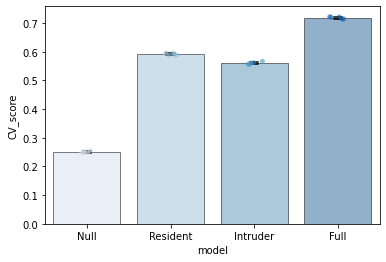

In [38]:
import seaborn as sns
scores_df_clean = pd.melt(scores_df, var_name='model', value_name='CV_score')
ax = sns.barplot(
    x="model", 
    y="CV_score", palette='Blues', 
    data=scores_df_clean, 
    ci="sd", 
    edgecolor="black",
    errcolor="black",
    errwidth=1.5,
    capsize = 0.1,
    alpha=0.5
)

sns.stripplot(
    x="model", 
    y="CV_score", palette = 'Blues', edgecolor = 'black',
    data=scores_df_clean, dodge=True, alpha=0.6, ax=ax)

plt.legend([],[], frameon=False)